# Trademark ducky dataset Phase Retrieval

> Georgios Varnavides | Dec 21 2025  
>
> Sample: graphene substrate ducky  
> Sampling conditions: 4 Ang step-sizes  
> Imaging conditions: 20 mrad, 500 A  

In [1]:
# %load_ext autoreload 
# %autoreload 2

In [2]:
import quantem as em
import numpy as np

/Users/gvarnavides/Documents/git-repos/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = em.core.io.load("../data/ducky_20mrad_500A-df_4A-step.zip")
dataset

Dataset(shape=(41, 41, 200, 200), dtype=float32, name='4D-STEM dataset')
  sampling: [4.         4.         1.04392901 1.04392901]
  units: ['A', 'A', 'mrad', 'mrad']
  signal units: 'arb. units'

In [4]:
energy = 80e3
semiangle_cutoff = 20
defocus = 500
rotation_angle = np.deg2rad(-15)

In [5]:
def add_poisson_noise(
    dataset,
    electrons_per_area,
):
    if electrons_per_area == np.inf:
        return dataset
    electrons_per_probe = electrons_per_area * dataset.sampling[:2].prod()
    
    dataset_noisy = dataset.copy()
    dataset_noisy.array = np.random.poisson(dataset.array * electrons_per_probe)
    return dataset_noisy

In [6]:
np.random.seed(2025)
noisy_dataset = add_poisson_noise(
    dataset,
    1e5
)

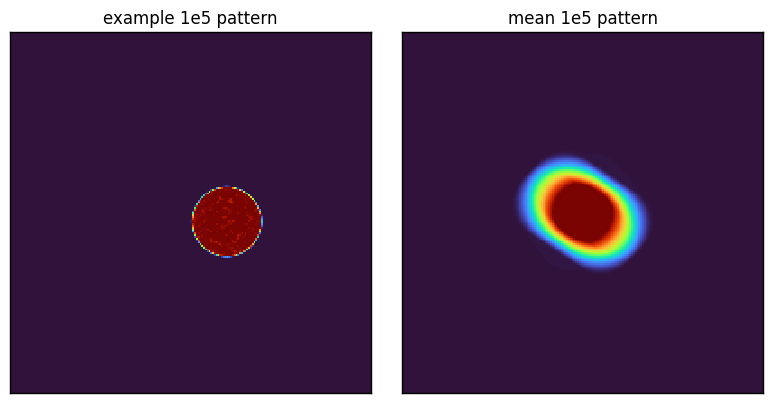

In [7]:
# notice the descan!
em.visualization.show_2d(
    [
        noisy_dataset[0,0].array,
        noisy_dataset.mean((0,1)),
    ],
    title=[
        "example 1e5 pattern","mean 1e5 pattern"
    ],
    power=0.5,
    cmap='turbo'
);

In [8]:
direct_ptycho = em.diffractive_imaging.DirectPtychography.from_dataset4d(
    noisy_dataset,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    rotation_angle=rotation_angle,
    aberration_coefs={"defocus":defocus},
    # device='gpu',
)

100%|██████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


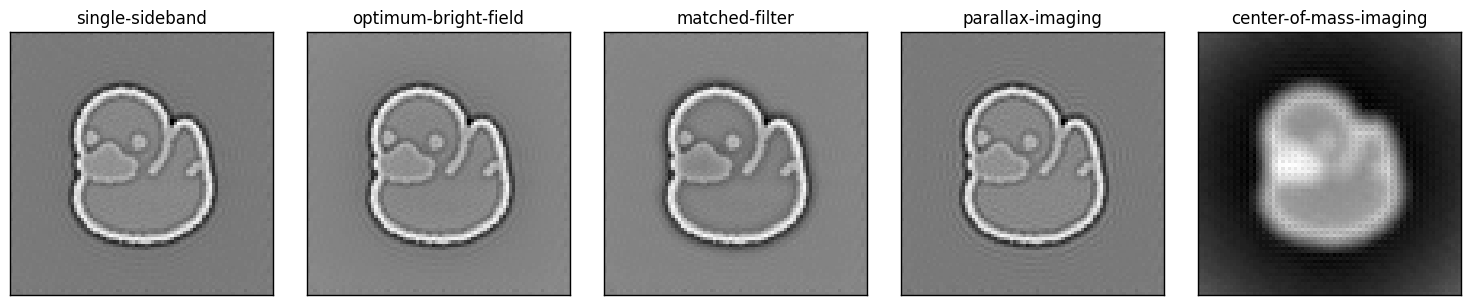

In [9]:
kwargs = {
    "title":["single-sideband","optimum-bright-field","matched-filter","parallax-imaging","center-of-mass-imaging"],
    "norm":"minmax",
    "axsize":(3,3),
}

recons = direct_ptycho._reconstruct_all_permutations(
    upsampling_factor=2,
)

em.visualization.show_2d(
    recons,
    **kwargs
);

Best trial: 201. Best value: 0.00484727: 100%|█████████████████| 250/250 [00:26<00:00,  9.36it/s]


HyperparameterState(
  optimized_aberrations={'defocus': 521.8314281285892},
)


100%|█████████████████████████████████████████████████████| 1153/1153 [00:00<00:00, 12387.60it/s]


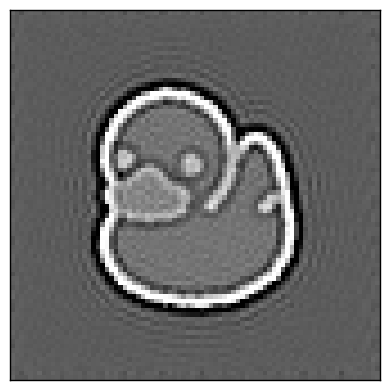

In [10]:
# Optimize defocus with optuna
direct_ptycho = direct_ptycho.optimize_hyperparameters(
    aberration_coefs={
        "defocus":em.diffractive_imaging.direct_ptychography.OptimizationParameter(
            0,1000
        )
    },
    n_trials=250,
    deconvolution_kernel='parallax',
)

em.visualization.show_2d(
    direct_ptycho.reconstruct_with_hyperparameters(
        deconvolution_kernel='parallax',
        upsampling_factor=2,
    ).obj
);

Aligning (reference): 100%|████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


HyperparameterState(
  optimized_aberrations={'C10': -529.37353515625, 'C12': 0.6138455867767334, 'phi12': -0.04066638648509979},
  optimized_rotation_angle=-0.26268553733825684,
)


100%|█████████████████████████████████████████████████████| 1153/1153 [00:00<00:00, 12418.81it/s]


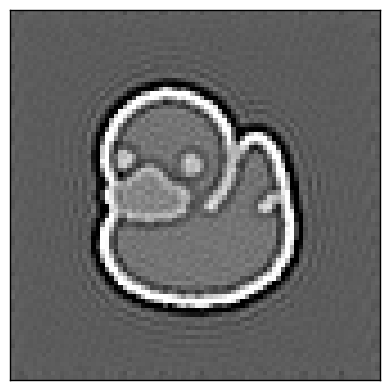

In [11]:
# reference fit from scratch (note the aberration_coeffs = {} and rotation_angle=0.0 arguments overriding init values)
direct_ptycho.fit_hyperparameters(
    alignment_method='reference',
    bin_factors=(3,2,1,1,1),

    # reset aberrations and rotation to prove it can find it from scratch.
    # in practice, you should pass a good guess, either here or (preferably) during initialization
    aberration_coefs = {},
    rotation_angle= 0.0,
);

em.visualization.show_2d(
    direct_ptycho.reconstruct_with_hyperparameters(
        deconvolution_kernel='parallax',
        upsampling_factor=2,
    ).obj
);